## **FDS project, winter semester 2023**

#### Tommaso Leonardi, Arianna Paolini, Stefano Saravalle, Paolo Cursi, Pietro Signorino
<leonardi.1914546@studenti.uniroma1.it>, <paolini.1943164@studenti.uniroma1.it>, <saravalle.1948684@studenti.uniroma1.it>, <paoloc1999@gmail.com>, <signorino.2149741@studenti.uniroma1.it>

# **Student Performance Analysis & Prediction**

In [1]:
%pip install -U imbalanced-learn
#import libraries
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import linear_model

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\stefa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


### **Data Preprocessing**

In [2]:
#loading the dataset tables
courses = pd.read_csv('./data/courses.csv')  #22 rows for courses (modules) and their presentations
assess = pd.read_csv('./data/assessments.csv')  #206 rows of assessments for module-presentations (including the final exam)
results = pd.read_csv('./data/studentAssessment.csv') #173,912 rows for the scores obtained by students in the asssesments
studs = pd.read_csv('./data/studentInfo.csv') #32,593 rows for demographic information on students and their results in module-presentations
registr = pd.read_csv('./data/studentRegistration.csv') #32,593 rows for student registration/unregistration on module-presentations
vle = pd.read_csv('./data/studentVle.csv') #10,655,280 rows for daily student interactions with online resources for a module-presentation
materials = pd.read_csv('./data/vle.csv') #6,364 rows for the materials available on the Virtual Learning Environment

The _Open University Learning Analytics dataset_ that we are considering has the following structure: 

 <img src="https://analyse.kmi.open.ac.uk/resources/images/model.png" alt="dataset structure" style="height: 500px; width:500px;"/>


(https://analyse.kmi.open.ac.uk/open_dataset)



Since our goal is to predict the score of each student in any assessment belonging to a specific module presentation, we consider the demographic information about students (from the table *studentInfo*) and their accessess to online resources in the Virtual Learning Environment (VLE) for each course (from the tables *studentVle* and *vle*) as features for our models. 

We also take in account the assessment type and weigth (from the table *assessments*) and the time the student spent before submitting it (from the table *studentAssessment*). 

The target value to predict is the score from the *studentAssessment* table, which ranges from 0 to 100.

In [3]:
#dropping some features
studs = studs.drop("final_result", axis=1)
registr = registr.drop("date_unregistration", axis=1)
materials = materials.drop(["week_from", "week_to"], axis=1)
vle = vle.drop("date", axis=1)
results = results.drop("is_banked", axis=1)

#remove Nan values in studs 'imd_band' (amounts to around 7000 total assessment results)
studs=studs.dropna()

#remove students with 'date registration' that is null (amounts to 7 total assessment results)
registr=registr.dropna()

#match info about a student and his date of registration to a module presentation
studs = studs.merge(registr, how="inner", on=["code_module", "code_presentation","id_student"])

#match a student's interactions with an online resource with the type of the resource
vle = vle.merge(materials, how="inner", on=["code_module", "code_presentation","id_site"] )
vle = vle.drop("id_site", axis=1)

#group the interactions by resource type and add a feature to consider the total sum of clicks for each resource type
temp = vle.groupby(["code_module", "code_presentation", "id_student", "activity_type"]).sum().reset_index()
for x in temp["activity_type"].unique():
    temp[x+"_clicks"] = np.where(temp["activity_type"]==x, temp["sum_click"], 0)
temp = temp.drop(["activity_type","sum_click"], axis=1)
temp = temp.groupby(["code_module", "code_presentation", "id_student"]).sum().reset_index()

#match student's information with his interactions on the VLE for a specific module presentation and fill nan with 0
studs = studs.merge(temp, how="left", on=["code_module", "code_presentation", "id_student"])
studs= studs.fillna(0)

#remove assessments without 'date'=nan and results with 'score'=nan
assess=assess.dropna()
results=results.dropna()
#a=results.merge(assess[assess['date'].isnull()], how="inner", on=["id_assessment"]) #only 2865 instances are removed

#match assessments with students scores
assess = assess.merge(results, how="inner", on="id_assessment")

#substitute date in assessment and date_submitted in results with their difference (to be considered as a time delay from expected submission)
assess["submission_delay"] = assess["date_submitted"] - assess["date"] #"date" is the deadline for the assessment
assess = assess.drop(["date","date_submitted"], axis=1)

#match students with their results
df = studs.merge(assess, how="inner", on=["code_module", "code_presentation","id_student"])

#remove ids from the features
df = df.drop(["code_module","code_presentation","id_student","id_assessment"], axis=1) 
print(df.shape) #163387 total rows

(163387, 33)


In [4]:
print(df[df['assessment_type'] == 'TMA']["score"].mean())
print(df[df['assessment_type'] == 'TMA']["score"].size)
print(df[df['assessment_type'] == 'CMA']["score"].mean())
print(df[df['assessment_type'] == 'CMA']["score"].size)
print(df[df['assessment_type'] == 'Exam']["score"].mean())
print(df[df['assessment_type'] == 'Exam']["score"].size)

72.36404324761064
94063
80.9637815612522
67369
62.994884910485936
1955


Some of the features in the dataset have *string* values (e.g. 'gender' has values {'M', 'F'}). 

We convert those features to integer values. The list *to_be_converted* contains the names of such features.

In [5]:
df["highest_education"] = df["highest_education"].replace({"No Formal quals":0, "Lower Than A Level":1, "A Level or Equivalent": 2, 
                                                           "HE Qualification":3, "Post Graduate Qualification":4 })

df["imd_band"] = df["imd_band"].replace({"0-10%":0, "10-20":1, "20-30%": 2, "30-40%":3, "40-50%":4, "50-60%":5,
                                          "60-70%":6, "70-80%":7, "80-90%":8, "90-100%":9 })

df["age_band"] = df["age_band"].replace({"0-35":0, "35-55":1, "55<=": 2})

to_be_converted = ["gender", "region", "disability", "assessment_type"]

for column_name in to_be_converted:

    values = set(df[column_name].tolist())
    print(f"Values in '{column_name}' column: {values}")

    mapping = {x : y for y,x in enumerate(values)}
    print(f"Mapping from string values to numerical using the following dictionary: {mapping}")

    df[column_name] = df[column_name].map(mapping)

    print("\n==================================================\n")


Values in 'gender' column: {'M', 'F'}
Mapping from string values to numerical using the following dictionary: {'M': 0, 'F': 1}


Values in 'region' column: {'East Anglian Region', 'Scotland', 'North Region', 'East Midlands Region', 'South West Region', 'Ireland', 'South East Region', 'South Region', 'Yorkshire Region', 'London Region', 'North Western Region', 'Wales', 'West Midlands Region'}
Mapping from string values to numerical using the following dictionary: {'East Anglian Region': 0, 'Scotland': 1, 'North Region': 2, 'East Midlands Region': 3, 'South West Region': 4, 'Ireland': 5, 'South East Region': 6, 'South Region': 7, 'Yorkshire Region': 8, 'London Region': 9, 'North Western Region': 10, 'Wales': 11, 'West Midlands Region': 12}


Values in 'disability' column: {'N', 'Y'}
Mapping from string values to numerical using the following dictionary: {'N': 0, 'Y': 1}


Values in 'assessment_type' column: {'Exam', 'TMA', 'CMA'}
Mapping from string values to numerical using the followin

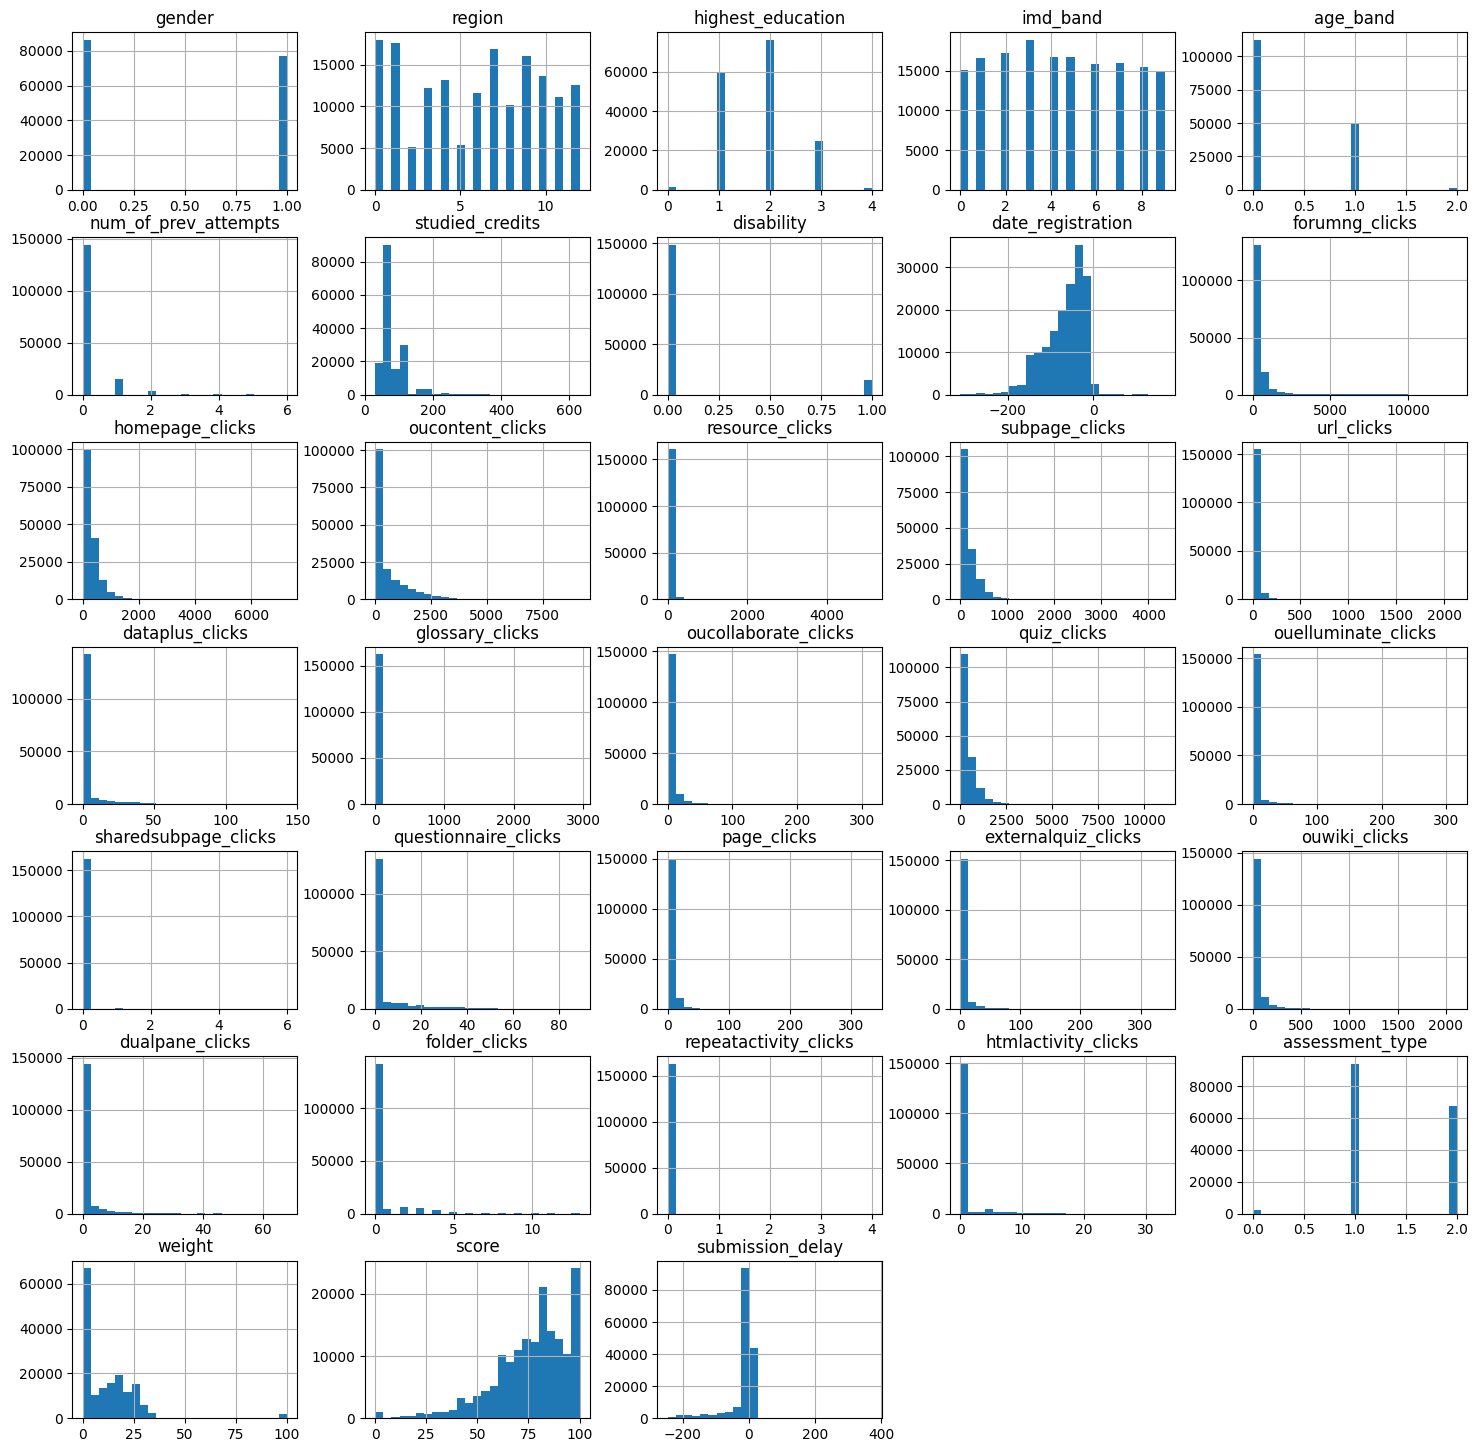

In [6]:
#showing the feature values
df.hist(layout=(7,5),figsize=(18, 18), bins=25)
plt.show()

With the previous step we have obtained a dataset containing only *integer values*.

We normalize every feature $f$ with values $vals$ and
- mean:  $mn$
- standard deviation:  $std$

with the following algorithm.

For each $v \in vals$:
$$
v := \frac{v - mn}{std}
$$

<!-- This step ensures that every value in the dataset is in the range $[0,1]$. -->

Let's also save a few values for later computations.

In [7]:
y_nn = df["score"].tolist()

In [8]:
for col in df:
    
    if col == "score": continue

    print(f"Normalizing column '{col}'")
    print("\n==================================================\n")

    df[col] = (df[col] - df[col].mean()) / df[col].std()

Normalizing column 'gender'


Normalizing column 'region'


Normalizing column 'highest_education'


Normalizing column 'imd_band'


Normalizing column 'age_band'


Normalizing column 'num_of_prev_attempts'


Normalizing column 'studied_credits'


Normalizing column 'disability'


Normalizing column 'date_registration'


Normalizing column 'forumng_clicks'


Normalizing column 'homepage_clicks'


Normalizing column 'oucontent_clicks'


Normalizing column 'resource_clicks'


Normalizing column 'subpage_clicks'


Normalizing column 'url_clicks'


Normalizing column 'dataplus_clicks'


Normalizing column 'glossary_clicks'


Normalizing column 'oucollaborate_clicks'


Normalizing column 'quiz_clicks'


Normalizing column 'ouelluminate_clicks'


Normalizing column 'sharedsubpage_clicks'


Normalizing column 'questionnaire_clicks'


Normalizing column 'page_clicks'


Normalizing column 'externalquiz_clicks'


Normalizing column 'ouwiki_clicks'


Normalizing column 'dualpane_clicks'


Normali

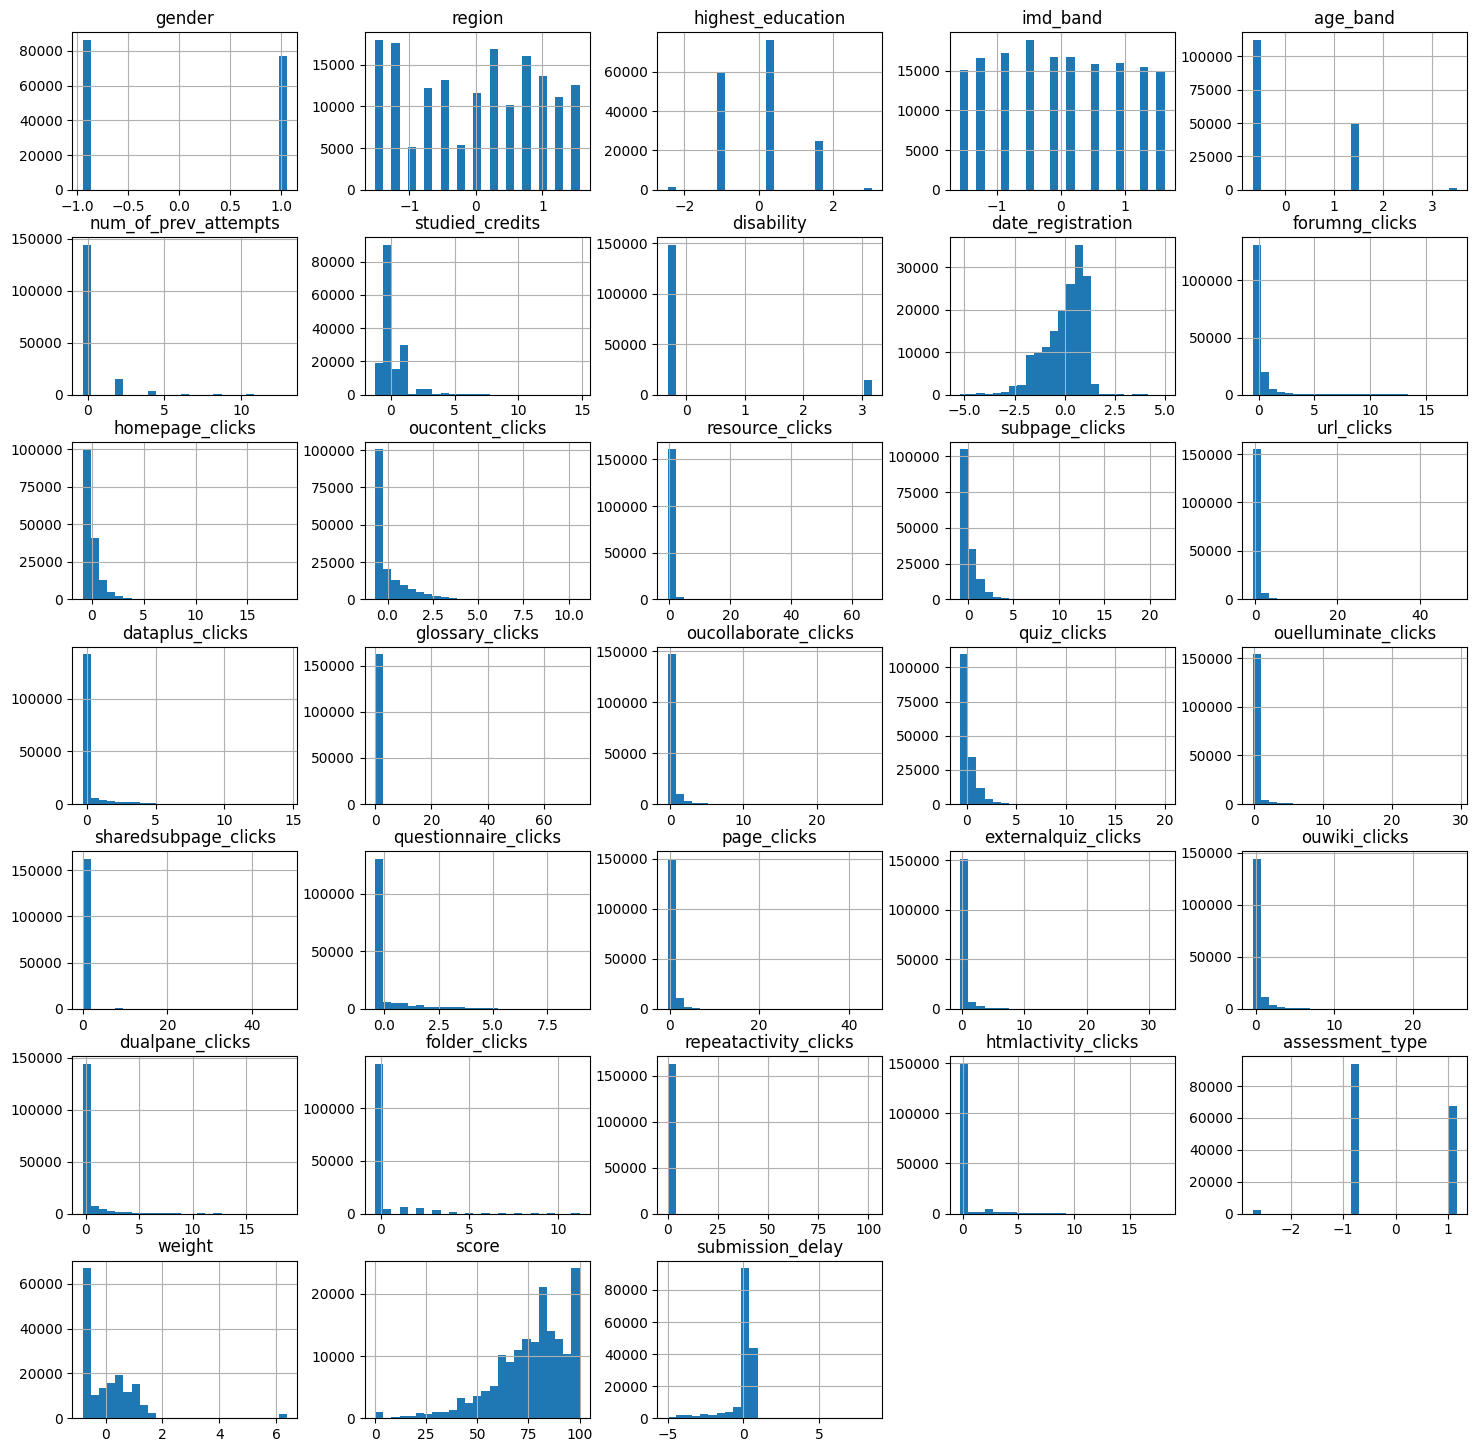

Column 'gender' has max value of 1.0586396604726935
Column 'region' has max value of 1.5597704435503643
Column 'highest_education' has max value of 3.0450965769712472
Column 'imd_band' has max value of 1.6279097821340263
Column 'age_band' has max value of 3.5125380037014544
Column 'num_of_prev_attempts' has max value of 13.007845039702666
Column 'studied_credits' has max value of 14.819496958952277
Column 'disability' has max value of 3.175616161701915
Column 'date_registration' has max value of 4.9770544172070315
Column 'forumng_clicks' has max value of 17.7757272371232
Column 'homepage_clicks' has max value of 18.820656142513954
Column 'oucontent_clicks' has max value of 10.597292648771141
Column 'resource_clicks' has max value of 66.56019757945391
Column 'subpage_clicks' has max value of 21.644176798963034
Column 'url_clicks' has max value of 49.08569973219772
Column 'dataplus_clicks' has max value of 14.55851262699177
Column 'glossary_clicks' has max value of 72.83521981498382
Colu

In [9]:
#showing the feature values after normalization
df.hist(layout=(7,5),figsize=(18, 18), bins=25)
plt.show()

for col in df:
    print(f"Column '{col}' has max value of {df[col].max()}")


In [10]:
df

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,forumng_clicks,...,externalquiz_clicks,ouwiki_clicks,dualpane_clicks,folder_clicks,repeatactivity_clicks,htmlactivity_clicks,assessment_type,weight,score,submission_delay
0,-0.944603,-1.517986,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,-0.086882,78.0,0.340851
1,-0.944603,-1.517986,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,0.632217,85.0,0.340851
2,-0.944603,-1.517986,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,0.632217,80.0,0.319025
3,-0.944603,-1.517986,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,0.632217,85.0,0.319025
4,-0.944603,-1.517986,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,1.351317,82.0,0.297199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163382,1.058640,0.533852,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,1.167032,-0.805982,100.0,-0.881397
163383,1.058640,0.533852,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,1.167032,-0.805982,100.0,-0.139318
163384,1.058640,0.533852,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,-0.805982,80.0,-0.161144
163385,1.058640,0.533852,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.779197,-0.805982,80.0,0.144418


To better understand the influence of each feature on the value we want to predict, we use some scatterplots to show the relationship between each single feature of the dataset and the score value for an assessment.

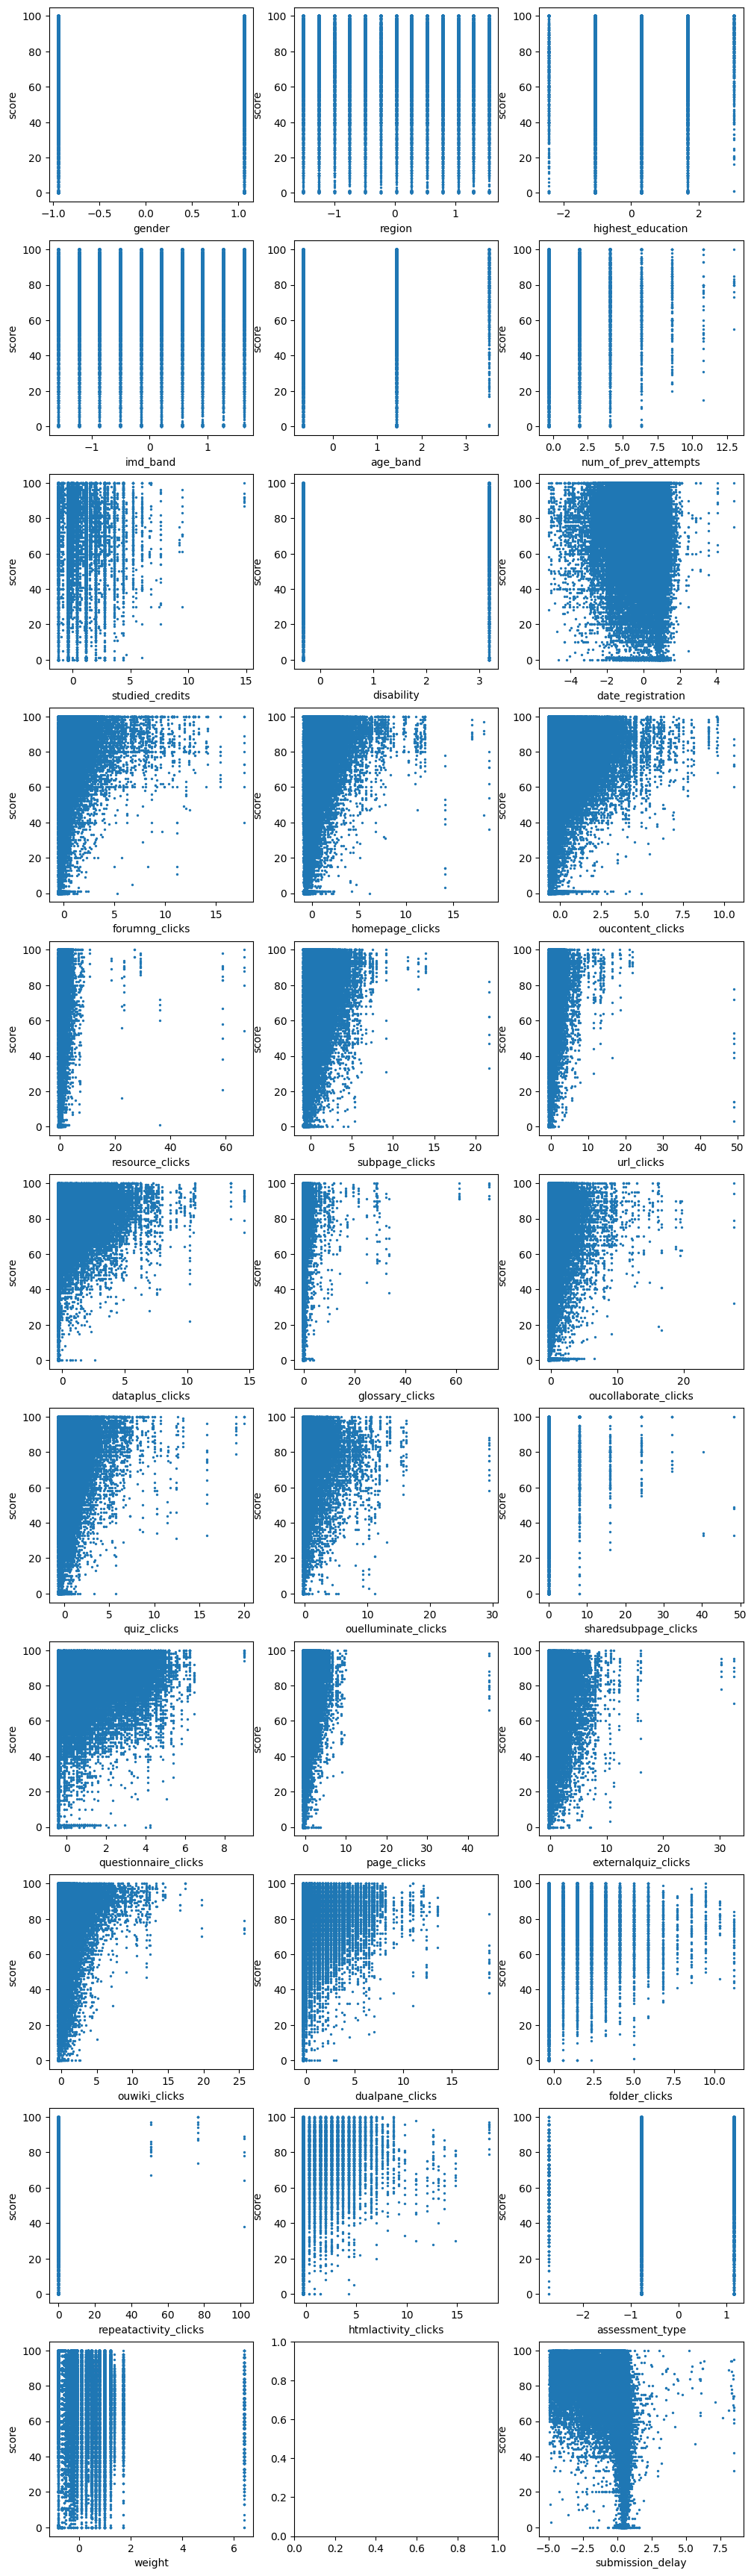

In [11]:
scatPlotRows=11
scatPlotColumns=3
figure, axis = plt.subplots(scatPlotRows,scatPlotColumns,figsize=(scatPlotColumns*4,scatPlotRows*4)) 
for i,col in enumerate(df):  
    if col=="score": continue  
    axis[i//scatPlotColumns,i%scatPlotColumns].scatter(df[col], df["score"],s=2)
    axis[i//scatPlotColumns,i%scatPlotColumns].set_xlabel(col)
    axis[i//scatPlotColumns,i%scatPlotColumns].set_ylabel("score")
plt.show()

We can see that there isn't a linear relationship between features and target, as we could imagine, so we don't expect linear models to perform very well.

We can also visualize the correlation between some features with a correlation matrix:

<Axes: >

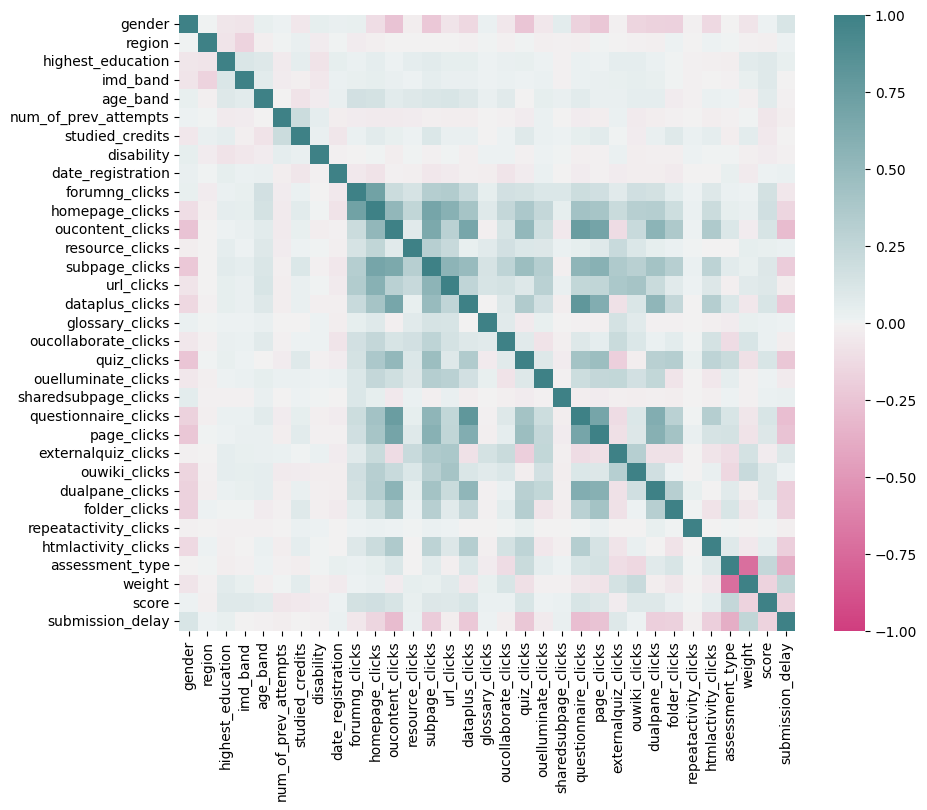

In [12]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sb.heatmap(corr,
    cmap=sb.diverging_palette(350, 200, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

We can see that the number of clicks on different types of resources are correlated to each other (just look at the green square of positive correlations in the image), most likely because they can be accessed sequentially in the same session on the VLE. Interestingly, we also can observe a slight negative correlation between the clicks and the submission delay (look for example at the red cells in the bottom row of the image), suggesting that students that are active on the VLE submitt an assessment with less delay compared to others.
Apart from that, the other features seems to not be correlated with each other.

We get the training and test sets for our ML models by splitting the dataset according to a given ratio between training and test samples. We choose to use 80% of the original number of samples for training and the remaining 20% for testing.

In [13]:
#using scikit-learn to split the dataset into train and test sets
X = df.drop("score", axis=1)
y = df["score"].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=7) #130709 train samples, 32678 test


def save_files(X_train, X_test, y_train, y_test, end_string = ""):
    X_train.to_csv(f"sets/X_train{end_string}.csv", index=False)
    X_test.to_csv(f"sets/X_test{end_string}.csv", index=False)
    y_train.to_csv(f"sets/y_train{end_string}.csv", index=False)
    y_test.to_csv(f"sets/y_test{end_string}.csv", index=False)

save_files(X_train, X_test, y_train, y_test)

# Over-Sampling
The following plot shows how *high* grades are much more present than *low* ones in the dataset.

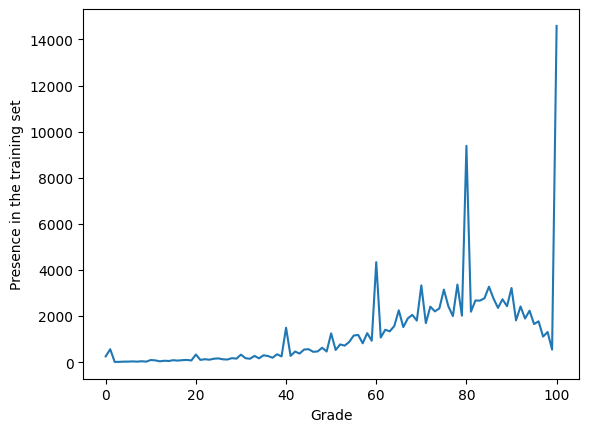

In [14]:
def plot_presence(y):
    plt.plot([i for i in range(101)], [np.count_nonzero(y == i) for i in range(101)])
    plt.xlabel("Grade")
    plt.ylabel("Presence in the training set")
    plt.show()
    
plot_presence(y_train)

## Random Over-Sampling
The first thing we can try to solve this problem is *Over-Sampling*.

In [15]:
# Uncomment if error
# !pip install imbalanced-leaddn
from imblearn.over_sampling import RandomOverSampler

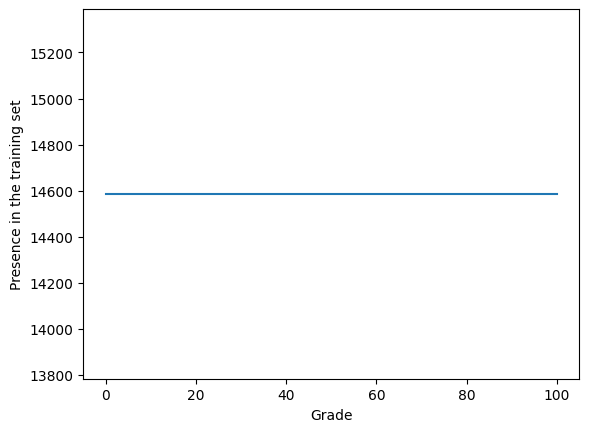

In [16]:
ros = RandomOverSampler(sampling_strategy="not majority")
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

plot_presence(y_resampled)

In [17]:
# Save to files
save_files(X_resampled, X_test, y_resampled, y_test, "_oversampled")